## Advice from first week

Competition data is rather challenging, so the sooner you get yourself familiar with it - the better. You can start with submitting sample_submission.csv from "Data" page on Kaggle and try submitting different constants.

## Advice from second week

A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly,  you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

## Advice from third week

You can get a rather good score after creating some lag-based features like in advice from previous week and feeding them into gradient boosted trees model.

Apart from item/shop pair lags you can try adding lagged values of total shop or total item sales (which are essentially mean-encodings). All of that is going to add some new information.

## Descriptions

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## File descriptions

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

## Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., - October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category


In [1]:
import pandas as pd
import re

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 1. Preprocessing data

In [2]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')

sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
items['item_category'] = items['item_category_id'].map(item_categories.set_index('item_category_id').to_dict()['item_category_name'])

In [5]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format="%d.%m.%Y")
sales_train = sales_train.sort_values(by='date')
sales_train = sales_train.reset_index(drop=True)
sales_train = sales_train.drop_duplicates()
sales_train['shop_location'] = sales_train['shop_id'].map(shops.set_index('shop_id').to_dict()['shop_name'])
sales_train['item_category'] = sales_train['item_id'].map(items['item_category'].to_dict())
sales_train['item_name'] = sales_train['item_id'].map(items['item_name'].to_dict())
sales_train['day'] = sales_train['date'].dt.day
sales_train['month'] = sales_train['date'].dt.month
sales_train['dayofweek'] = sales_train['date'].dt.day_name()
sales_train['year'] = sales_train['date'].dt.year
#sales_train['date_block_num'] = (sales_train['year'] - 2013) * 12 + sales_train['month'] - 1
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_location,item_category,item_name,day,month,dayofweek,year
0,2013-01-01,0,18,5823,2500.0,1.0,"Красноярск ТЦ ""Июнь""",Карты оплаты - PSN,Playstation Store пополнение бумажника: Карта ...,1,1,Tuesday,2013
1,2013-01-01,0,27,5573,849.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",Аксессуары - PS3,PS Move Motion Controller Charger (Зарядная ст...,1,1,Tuesday,2013
2,2013-01-01,0,7,1006,399.0,1.0,"Воронеж ТРЦ ""Максимир""",Подарки - Развитие,3D Crystal Puzzle Дельфин XL,1,1,Tuesday,2013
3,2013-01-01,0,19,17707,899.0,1.0,"Курск ТЦ ""Пушкинский""",Игры - PS3,Праздник спорта (Essentials) (только для PS Mo...,1,1,Tuesday,2013
4,2013-01-01,0,14,19548,149.0,1.0,"Казань ТЦ ""ПаркХаус"" II",Кино - DVD,ТАКИЕ РАЗНЫЕ БЛИЗНЕЦЫ (регион),1,1,Tuesday,2013


In [6]:
def get_category(row):
    if len(row.split(' - ')) == 1:
        return row
    
    category, subcategory = row.split(' - ')
    return category

def get_subcategory(row):
    if len(row.split(' - ')) == 1:
        return 'Прочие'
    
    category, subcategory = row.split(' - ')
    return subcategory

sales_train['category'] = sales_train['item_category'].apply(get_category)
sales_train['subcategory']  = sales_train['item_category'].apply(get_subcategory)

sales_train['location'] = sales_train['shop_location'].apply(lambda x: x.split()[0])
sales_train.loc[sales_train['location'] == '!Якутск', 'location'] = 'Якутск'
sales_train.loc[sales_train['location'] == 'Цифровой', 'location'] = 'Интернет-магазин'



def shop_type(row):
    inter = re.search('\s[\w\-]+\s\"[\s\w\-]*"', row)
    
    if inter is None:
        return 'Прочие'
    
    result = inter.group().split()[0]
    
    return result

sales_train['shop_type'] = sales_train['shop_location'].apply(shop_type)
sales_train.loc[sales_train['shop_type'] == 'Сити-Парк', 'shop_type'] = 'ТРЦ'

sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_location,item_category,item_name,day,month,dayofweek,year,category,subcategory,location,shop_type
0,2013-01-01,0,18,5823,2500.0,1.0,"Красноярск ТЦ ""Июнь""",Карты оплаты - PSN,Playstation Store пополнение бумажника: Карта ...,1,1,Tuesday,2013,Карты оплаты,PSN,Красноярск,ТЦ
1,2013-01-01,0,27,5573,849.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",Аксессуары - PS3,PS Move Motion Controller Charger (Зарядная ст...,1,1,Tuesday,2013,Аксессуары,PS3,Москва,ТЦ
2,2013-01-01,0,7,1006,399.0,1.0,"Воронеж ТРЦ ""Максимир""",Подарки - Развитие,3D Crystal Puzzle Дельфин XL,1,1,Tuesday,2013,Подарки,Развитие,Воронеж,ТРЦ
3,2013-01-01,0,19,17707,899.0,1.0,"Курск ТЦ ""Пушкинский""",Игры - PS3,Праздник спорта (Essentials) (только для PS Mo...,1,1,Tuesday,2013,Игры,PS3,Курск,ТЦ
4,2013-01-01,0,14,19548,149.0,1.0,"Казань ТЦ ""ПаркХаус"" II",Кино - DVD,ТАКИЕ РАЗНЫЕ БЛИЗНЕЦЫ (регион),1,1,Tuesday,2013,Кино,DVD,Казань,ТЦ


<AxesSubplot:xlabel='item_price', ylabel='item_cnt_day'>

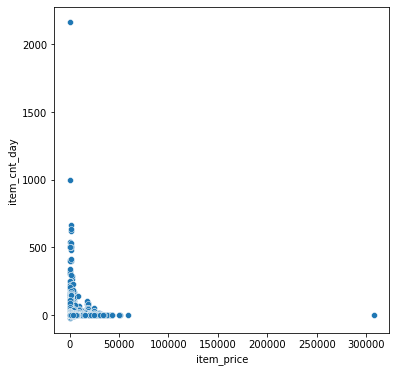

In [7]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x=sales_train['item_price'], y=sales_train['item_cnt_day'])

/home/magleb/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/magleb/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_cnt_day'>

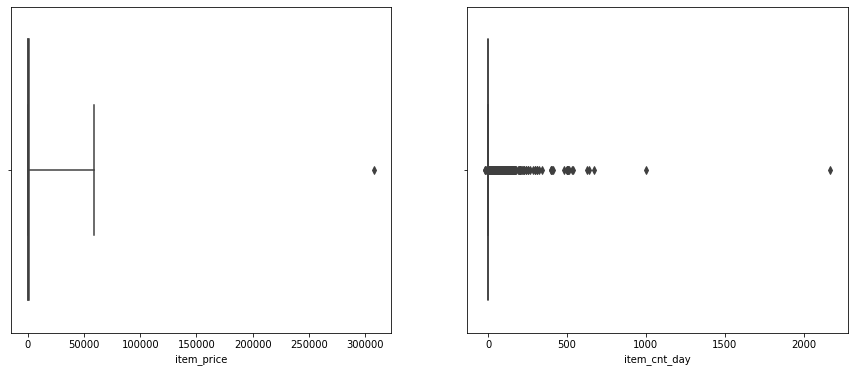

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(sales_train['item_price'], ax=ax1, whis=99)
sns.boxplot(sales_train['item_cnt_day'], ax=ax2, whis=99)

Text(0.5, 1.0, 'Distribution for "item_cnt_day" by date.')

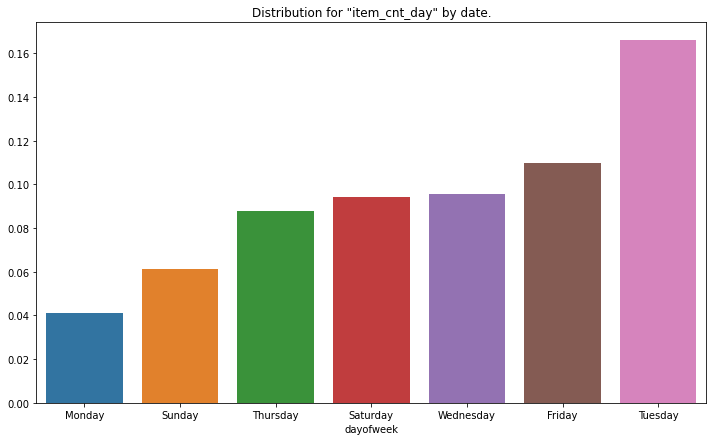

In [15]:
plt.figure(figsize=(12, 7))

x = sales_train.groupby('dayofweek')['item_cnt_day'].mean().sort_values().index
y = sales_train.groupby('dayofweek')['item_cnt_day'].mean().sort_values().values - 1.15

sns.barplot(x=x, y=y)

plt.title('Distribution for "item_cnt_day" by date.')

Text(0.5, 1.0, 'Distribution for "item_cnt_day" by date.')

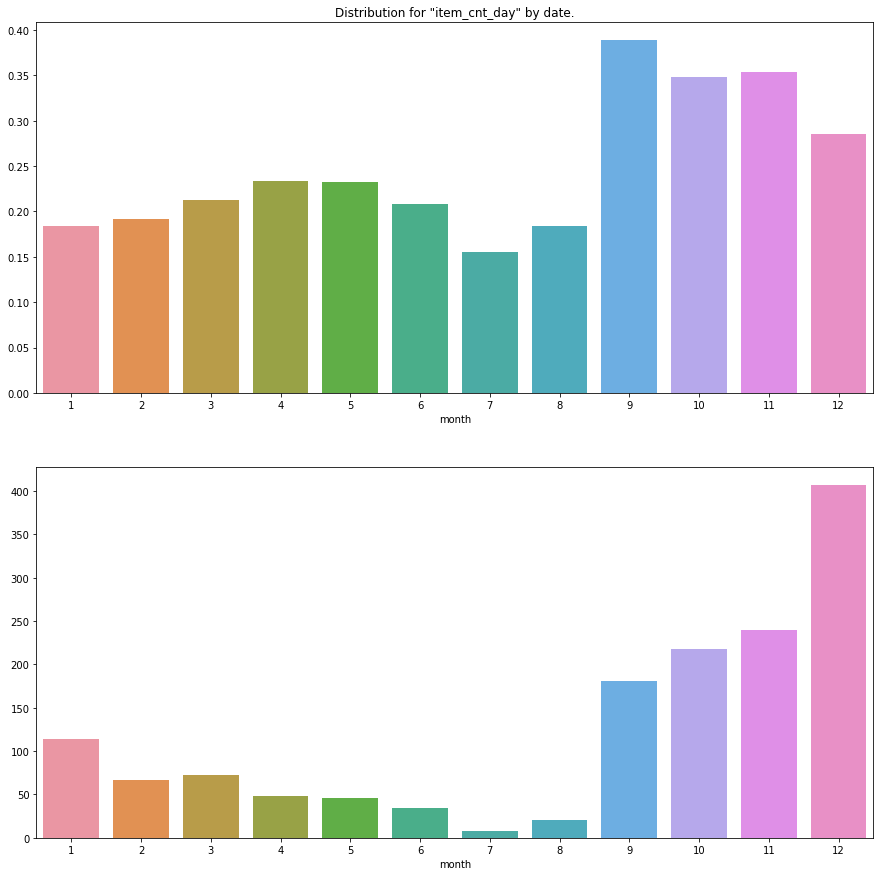

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

x = sales_train.groupby('month')['item_cnt_day'].mean().index
y = sales_train.groupby('month')['item_cnt_day'].mean().values - 1

sns.barplot(x=x, y=y, ax=ax1)

x = sales_train.groupby('month')['item_price'].mean().index
y = sales_train.groupby('month')['item_price'].mean().values - 770

sns.barplot(x=x, y=y, ax=ax2)

ax1.set_title('Distribution for "item_cnt_day" by date.')

Text(0.5, 1.0, 'Distribution for "item_cnt_day" by date.')

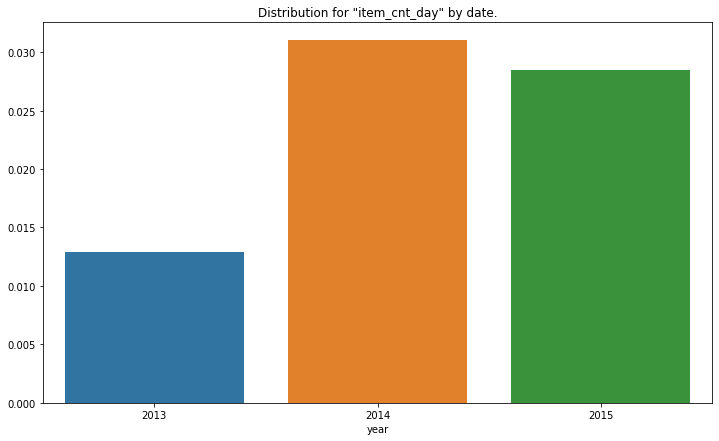

In [11]:
plt.figure(figsize=(12, 7))

x = sales_train.groupby('year')['item_cnt_day'].mean().index
y = sales_train.groupby('year')['item_cnt_day'].mean().values - 1.22

sns.barplot(x=x, y=y)

plt.title('Distribution for "item_cnt_day" by date.')

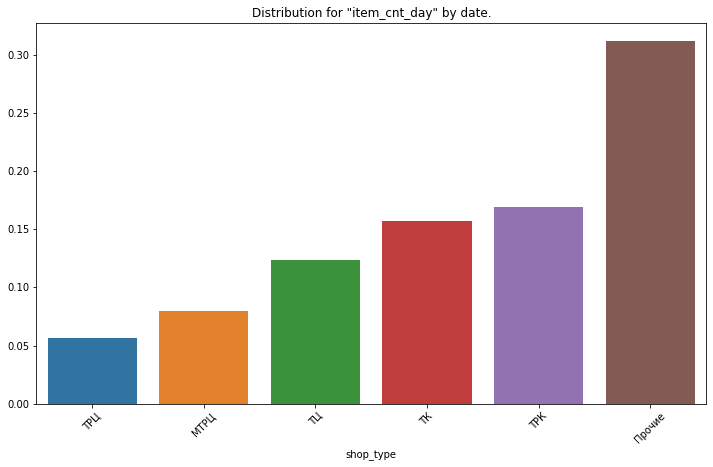

In [12]:
plt.figure(figsize=(12, 7))

x = sales_train.groupby('shop_type')['item_cnt_day'].mean().sort_values().index
y = sales_train.groupby('shop_type')['item_cnt_day'].mean().sort_values().values - 1.1

sns.barplot(x=x, y=y)

plt.title('Distribution for "item_cnt_day" by date.')
_ = plt.xticks(rotation=45)

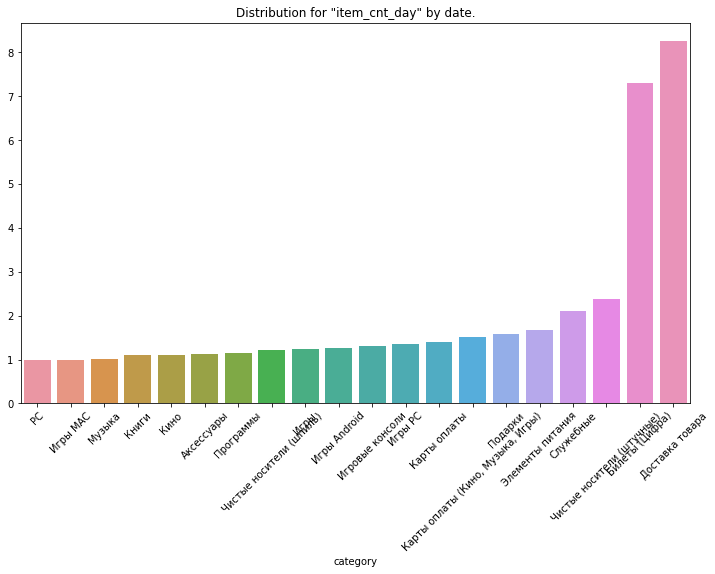

In [17]:
plt.figure(figsize=(12, 7))

x = sales_train.groupby('category')['item_cnt_day'].mean().sort_values().index
y = sales_train.groupby('category')['item_cnt_day'].mean().sort_values().values

sns.barplot(x=x, y=y)

plt.title('Distribution for "item_cnt_day" by date.')
_ = plt.xticks(rotation=45)

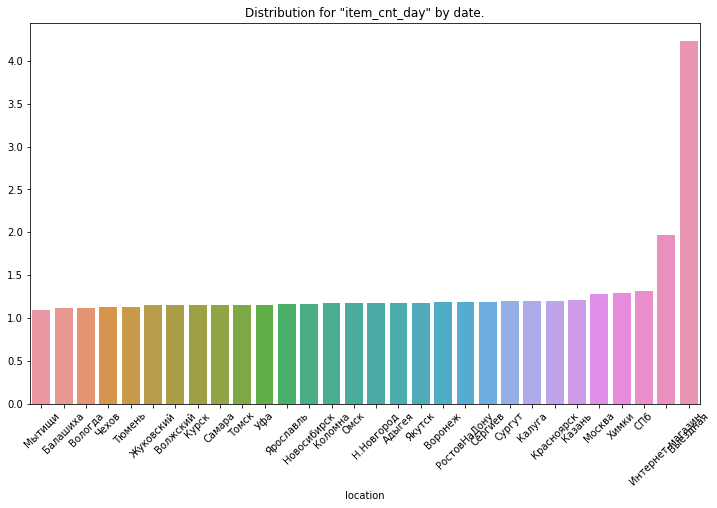

In [14]:
plt.figure(figsize=(12, 7))

x = sales_train.groupby('location')['item_cnt_day'].mean().sort_values().index
y = sales_train.groupby('location')['item_cnt_day'].mean().sort_values().values

sns.barplot(x=x, y=y)

plt.title('Distribution for "item_cnt_day" by date.')
_ = plt.xticks(rotation=45)

## NEW ERA

In [20]:
sales_train.drop(['shop_location', 'item_category', 'item_name'], axis=1, inplace=True)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,dayofweek,year,category,subcategory,location,shop_type
0,2013-01-01,0,18,5823,2500.0,1.0,1,1,Tuesday,2013,Карты оплаты,PSN,Красноярск,ТЦ
1,2013-01-01,0,27,5573,849.0,1.0,1,1,Tuesday,2013,Аксессуары,PS3,Москва,ТЦ
2,2013-01-01,0,7,1006,399.0,1.0,1,1,Tuesday,2013,Подарки,Развитие,Воронеж,ТРЦ
3,2013-01-01,0,19,17707,899.0,1.0,1,1,Tuesday,2013,Игры,PS3,Курск,ТЦ
4,2013-01-01,0,14,19548,149.0,1.0,1,1,Tuesday,2013,Кино,DVD,Казань,ТЦ


In [21]:
_ = sales_train.groupby(['shop_id', 'item_id', 'month', 'year']).mean()
_ = _.reset_index()
_

,shop_id,item_id,month,year,date_block_num,item_price,item_cnt_day,day
0,0,30,2,2013,1.0,265.0,3.444444,19.777778
1,0,31,2,2013,1.0,434.0,1.571429,20.714286
2,0,32,1,2013,0.0,221.0,1.500000,20.000000
3,0,32,2,2013,1.0,221.0,1.428571,14.428571
4,0,33,1,2013,0.0,347.0,1.000000,16.000000
...,...,...,...,...,...,...,...,...
1609119,59,22164,4,2015,27.0,699.0,1.000000,26.000000
1609120,59,22164,7,2015,30.0,699.0,1.000000,21.000000
1609121,59,22167,6,2014,17.0,299.0,1.000000,14.000000
1609122,59,22167,10,2013,9.0,299.0,1.000000,25.000000


In [22]:
_[(_['month'] == 10) & (_['year'] == 2015)]

,shop_id,item_id,month,year,date_block_num,item_price,item_cnt_day,day
8113,2,31,10,2015,33.0,399.0,1.0,25.000000
8204,2,486,10,2015,33.0,300.0,1.0,14.666667
8254,2,787,10,2015,33.0,420.0,1.0,22.000000
8284,2,794,10,2015,33.0,3300.0,1.0,4.000000
8367,2,968,10,2015,33.0,58.0,1.0,17.000000
...,...,...,...,...,...,...,...,...
1608994,59,22087,10,2015,33.0,119.0,2.0,15.333333
1609026,59,22088,10,2015,33.0,119.0,1.0,15.000000
1609043,59,22091,10,2015,33.0,179.0,1.0,3.000000
1609073,59,22100,10,2015,33.0,629.0,1.0,18.000000


In [ ]:
test

In [ ]:
def save_submission(name, prediction):
    submission = pd.DataFrame(columns=['ID', 'item_cnt_month'])
    submission['item_cnt_month'] = prediction
    submission['ID'] = submission.index
    submission.to_csv(name, index=False)
    
    print("File was submitted to path: {}".format(name))
    

In [ ]:
sample_submission['item_cnt_month'] = 1
save_submission('sample_sub_1.csv', sample_submission['item_cnt_month'])